In [1]:
import numpy as np
import pandas as pd
import uproot as ur

from keras.layers import Dense, Input
from keras.models import Model

import omnifold as of
import os
import tensorflow as tf

from matplotlib import pyplot as plt
from IPython.display import Image
pd.set_option('display.max_columns', None) # to see all columns of df.head()

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# [Omnifold Paper](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.124.182001) Background

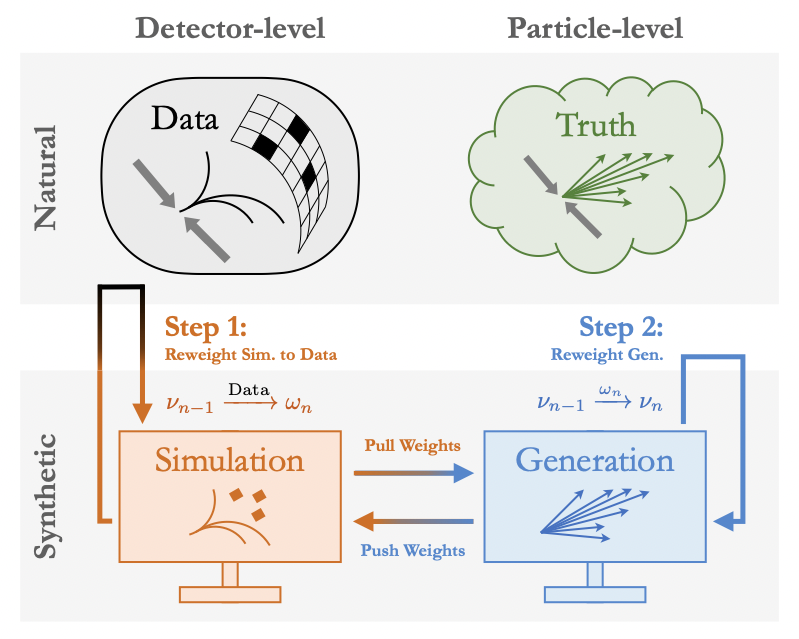

In [3]:
Image(filename='Omnifold.png') 

|   |   |   |
|---|---|---|
|Synthetic Generator-Level Sim   | $\theta_{0,G}$  | Truth-Level Sim  |
|Synthetic Reconstruction-Level Sim   | $\theta_{0,S}$   | Full Reco-Level Sim  |
|Natural Reconstruction  | $\theta_\mathrm{unknown,S}$  | Observed Detector Data  |
|Natural Truth   |$\theta_\mathrm{unknown,G}$   | Nature  |


___
___

# OmniFold Example 1: 1D Gaussian [[Original Repo](https://github.com/hep-lbdl/OmniFold)]

In [4]:
N_Events = 10**5

#Synthetic
theta0_G = np.random.normal(0.2,0.8,N_Events)  # Generator-level synthetic sample
theta0_S = np.array([(x + np.random.normal(0, 0.5)) for x in theta0_G])  # Detector smearing for synthetic sample

theta0 = np.stack([theta0_G, theta0_S], axis=1)

#Natural
theta_unknown_G = np.random.normal(0,1, N_Events)
theta_unknown_S = np.array([(x + np.random.normal(0, 0.5)) for x in theta_unknown_G]) 

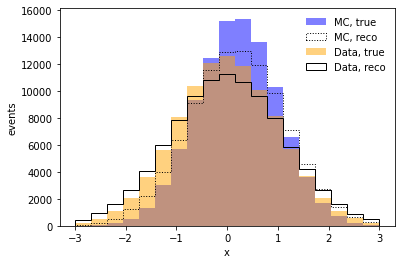

In [5]:
_,_,_=plt.hist(theta0_G,bins=np.linspace(-3,3,20),color='blue',alpha=0.5,label="MC, true")
_,_,_=plt.hist(theta0_S,bins=np.linspace(-3,3,20),histtype="step",color='black',ls=':',label="MC, reco")
_,_,_=plt.hist(theta_unknown_G,bins=np.linspace(-3,3,20),color='orange',alpha=0.5,label="Data, true")
_,_,_=plt.hist(theta_unknown_S,bins=np.linspace(-3,3,20),histtype="step",color='black',label="Data, reco")
plt.xlabel("x")
plt.ylabel("events")
plt.legend(frameon=False)

### Define the Model Architecture

In [6]:
inputs = Input((1, ))
hidden_layer_1 = Dense(50, activation='relu')(inputs)
hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
outputs = Dense(1, activation='sigmoid')(hidden_layer_3)
model_gaus = Model(inputs=inputs, outputs=outputs)

2022-10-07 09:23:31.099802: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-07 09:23:31.666985: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 20540 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:01:00.0, compute capability: 7.5


In [7]:
N_Iterations = 2
myweights = of.omnifold(theta0_G,theta0_S,theta_unknown_S,N_Iterations,model_gaus)

2022-10-07 09:23:32.006223: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


### Plot Omnifold, the weighted $\theta_G$ distribution

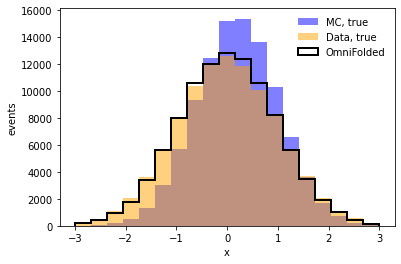

In [8]:
_,_,_=plt.hist(theta0_G,bins=np.linspace(-3,3,20),color='blue',alpha=0.5,label="MC, true")
_,_,_=plt.hist(theta_unknown_G,bins=np.linspace(-3,3,20),color='orange',alpha=0.5,label="Data, true")
_,_,_=plt.hist(theta0_G,weights=myweights[-1, 0, :], bins=np.linspace(-3,3,20),color='black',histtype="step",label="OmniFolded",lw="2")
plt.xlabel("x")
plt.ylabel("events")
plt.legend(frameon=False)

### $\rightarrow$ Try increasing from 2 to 5 iterations yourself

___
___

# Omnifold Example 2: Realistic DIS Reconstruction – Lepton + HFS

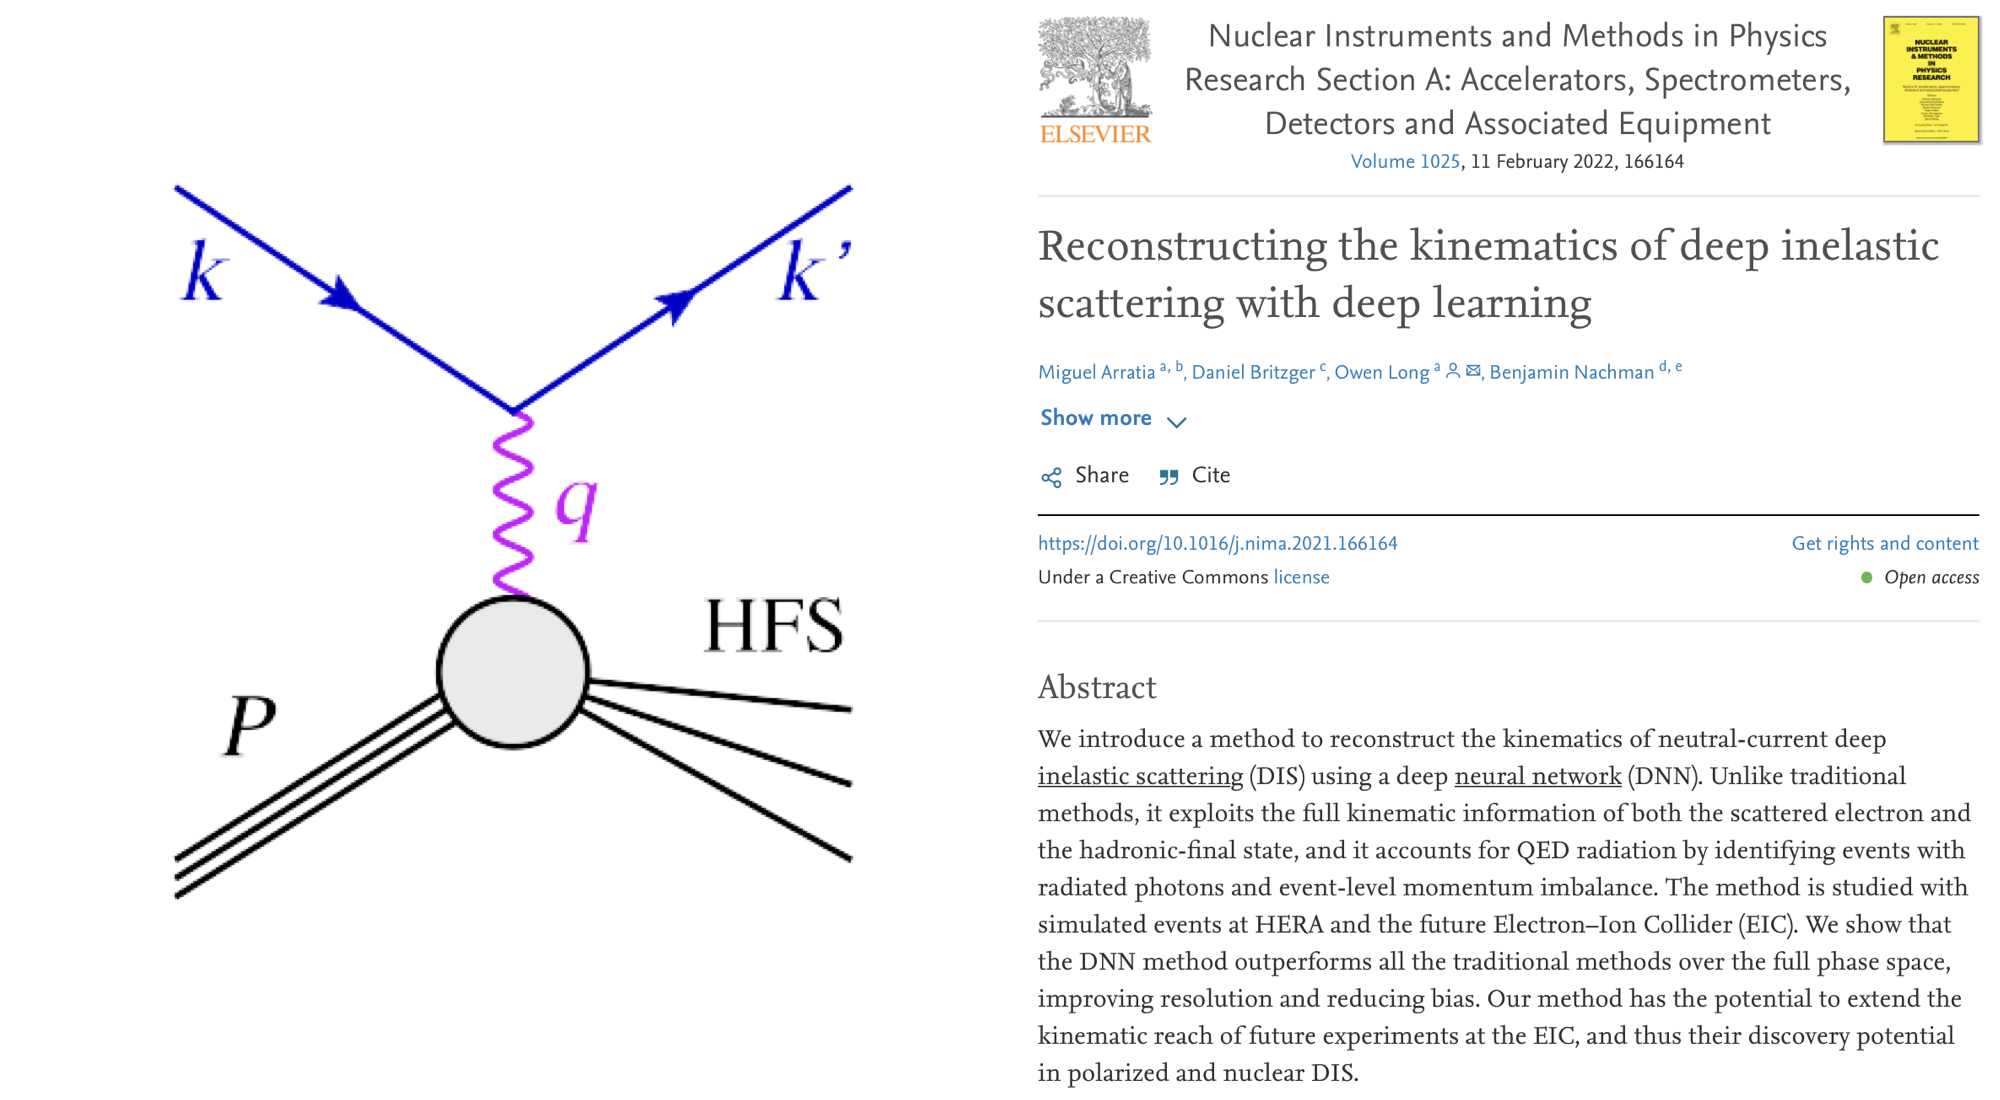

In [9]:
Image(filename='DIS_ML.png')

### Many thanks to _Miguel Arratia, Owen Long_, and _Daniel Britzger_ for letting us use their data from this awesome [paper   ](https://www.sciencedirect.com/science/article/pii/S0168900221010445?ref=cra_js_challenge&fr=RR-1) on reconstructing DIS events using Deep Learning.

### Import "Natural." In this tutorial, reconstructed-level Django will be our proxy of *_measured data_*.

In [10]:
natural_file = "all-h1-django.root"
natural_tree = ur.open("%s:Django/minitree"%(natural_file))
natural_df = natural_tree.arrays(library="pd") #open the TTree as a pandas data frame
natural_df = natural_df[natural_df["obs_hfs_pt"] != 0] #remove empty entries

### Take a quick look at the data

In [11]:
natural_df.describe()

,wgt,Empz,from_tlv_gen_Q2,from_tlv_gen_x,from_tlv_gen_y,beam_e_e,beam_p_e,has_isr,has_fsr,gen_e_e,gen_e_pz,gen_e_pt,gen_e_phi,gen_e_eta,gen_hfs_e,gen_hfs_pz,gen_hfs_pt,gen_hfs_phi,gen_hfs_eta,gen_dphi,obs_e_e,obs_e_pz,obs_e_pt,obs_e_phi,obs_e_eta,obs_hfs_e,obs_hfs_pz,obs_hfs_pt,obs_hfs_phi,obs_hfs_eta,obs_dphi,obs_x[0],obs_x[1],obs_x[2],obs_x[3],obs_x[4],obs_x[5],obs_x[6],obs_x[7],obs_x[8],obs_y[0],obs_y[1],obs_y[2],obs_y[3],obs_y[4],obs_y[5],obs_y[6],obs_y[7],obs_y[8],obs_Q2[0],obs_Q2[1],obs_Q2[2],obs_Q2[3],obs_Q2[4],obs_Q2[5],obs_Q2[6],obs_Q2[7],obs_Q2[8],phi_pho_closest_to_ebeam,eta_pho_closest_to_ebeam,e_pho_closest_to_ebeam,tower_sum_40,n_towers_40,obs_e_trk_e,obs_e_trk_eta,obs_e_trk_phi
count,1.854449e+07,1.854449e+07,1.854449e+07,1.854449e+07,1.854449e+07,1.854449e+07,18544494.0,1.854449e+07,1.854449e+07,1.854449e+07,1.854449e+07,1.854449e+07,1.854449e+07,1.854449e+07,1.854449e+07,1.854449e+07,1.854449e+07,1.854449e+07,1.854449e+07,1.854449e+07,1.854449e+07,1.854449e+07,1.854449e+07,1.854449e+07,1.854449e+07,1.854449e+07,1.854449e+07,1.854449e+07,1.854449e+07,1.854449e+07,1.854449e+07,1.854449e+07,1.854449e+07,1.854449e+07,1.854449e+07,1.854449e+07,1.854449e+07,1.854449e+07,1.854449e+07,1.854449e+07,1.854449e+07,1.854449e+07,1.854449e+07,1.854449e+07,1.854449e+07,1.854449e+07,1.854449e+07,1.854449e+07,1.854449e+07,1.854449e+07,1.854449e+07,1.854449e+07,1.854449e+07,1.854449e+07,1.854449e+07,1.854449e+07,1.854449e+07,1.854449e+07,1.854449e+07,1.854449e+07,1.854449e+07,1.854449e+07,1.854449e+07,1.854449e+07,1.854449e+07,1.854449e+07
mean,1.664617e-02,5.439791e+01,5.255795e+02,3.245262e-02,3.310986e-01,2.760060e+01,920.0,1.827874e-01,1.916692e-01,2.299650e+01,-1.336011e+01,1.635000e+01,-7.094713e-02,-8.630196e-01,9.242723e+02,9.060650e+02,1.636849e+01,4.377592e-02,-5.387600e+03,3.141588e+00,2.290076e+01,-1.333553e+01,1.626244e+01,-7.049360e-02,-8.645027e-01,9.059511e+01,7.247730e+01,1.633894e+01,4.985070e-02,2.012318e+00,3.135979e+00,-4.880252e-02,2.764815e-02,3.067529e-02,2.792462e-02,2.725288e-02,2.980146e-02,2.768099e-02,2.768099e-02,2.980146e-02,3.435461e-01,3.282237e-01,3.282237e-01,3.344944e-01,3.282237e-01,3.341675e-01,3.344944e-01,3.344944e-01,3.418985e-01,5.279991e+02,4.813118e+02,5.419625e+02,5.351466e+02,5.566314e+02,5.231646e+02,5.242632e+02,5.360048e+02,5.279991e+02,2.631127e-02,-2.458166e-01,2.144804e+00,2.281612e+01,1.041341e+00,3.781474e+01,-7.355577e-01,4.134766e-02
std,2.400343e-02,3.440239e+00,8.826135e+02,6.072535e-02,1.915288e-01,0.000000e+00,0.0,3.864921e-01,3.936142e-01,9.673262e+00,9.708840e+00,9.073822e+00,1.765191e+00,4.256274e-01,9.740741e+00,9.664464e+00,9.077737e+00,1.844990e+00,2.322162e+07,2.248228e-02,9.667523e+00,9.691292e+00,9.037683e+00,1.764762e+00,4.250866e-01,6.035880e+01,6.370792e+01,9.311875e+00,1.847059e+00,8.025393e-01,1.797570e-01,4.004209e+02,8.141020e-01,1.494771e+00,8.030665e-01,4.719184e-01,1.351898e+00,7.629229e-01,7.629229e-01,1.351898e+00,1.926267e-01,1.863653e-01,1.863653e-01,1.891521e-01,1.863653e-01,1.879612e-01,1.891521e-01,1.891521e-01,1.952187e-01,8.929847e+02,9.237899e+02,9.501101e+02,9.015175e+02,1.717945e+04,8.912341e+02,8.949578e+02,9.201810e+02,8.929847e+02,1.826393e+00,1.237768e+00,6.551149e+00,9.828958e+00,2.784438e-01,7.435480e+04,9.571233e-01,1.897463e+00
min,8.616587e-03,4.500001e+01,1.860699e+01,5.976123e-04,9.397853e-04,2.760000e+01,920.0,0.000000e+00,0.000000e+00,5.874212e-01,-2.601511e+01,4.926705e-02,-3.141588e+00,-1.891119e+00,4.133670e+02,3.678982e+02,4.925784e-02,-3.141550e+00,-1.000000e+11,1.002533e-01,1.100000e+01,-2.966030e+01,4.750370e+00,-3.141586e+00,-1.502274e+00,-2.747070e-02,-2.546879e+01,1.222056e-02,-3.141593e+00,-3.595400e+00,7.033550e-04,-1.708732e+06,-4.687922e+02,-5.205539e+02,-1.113156e+02,-4.345170e+02,-4.914932e+02,-1.081547e+02,-1.081547e+02,-4.914932e+02,-1.615210e-01,-2.155262e-02,-2.155262e-02,-3.978052e-01,-2.155262e-02,-2.240811e-02,-3.978052e-01,-3.978052e-01,-2.329755e-02,5.924049e+01,-5.142937e+02,-3.091317e+04,-1.080158e+0

## Import the Synthetic simulation [Rapgap], both generated and reconstructed level.

In [12]:
synthetic_file = "all-h1-rapgap.root"
synth_tree = ur.open("%s:Rapgap/minitree"%(synthetic_file))
synth_df = synth_tree.arrays(library="pd")
synth_df = synth_df[synth_df["obs_hfs_pt"] != 0]

In [13]:
synth_df.head(3) #look at 3 entries

,wgt,Empz,from_tlv_gen_Q2,from_tlv_gen_x,from_tlv_gen_y,beam_e_e,beam_p_e,has_isr,has_fsr,gen_e_e,gen_e_pz,gen_e_pt,gen_e_phi,gen_e_eta,gen_hfs_e,gen_hfs_pz,gen_hfs_pt,gen_hfs_phi,gen_hfs_eta,gen_dphi,obs_e_e,obs_e_pz,obs_e_pt,obs_e_phi,obs_e_eta,obs_hfs_e,obs_hfs_pz,obs_hfs_pt,obs_hfs_phi,obs_hfs_eta,obs_dphi,obs_x[0],obs_x[1],obs_x[2],obs_x[3],obs_x[4],obs_x[5],obs_x[6],obs_x[7],obs_x[8],obs_y[0],obs_y[1],obs_y[2],obs_y[3],obs_y[4],obs_y[5],obs_y[6],obs_y[7],obs_y[8],obs_Q2[0],obs_Q2[1],obs_Q2[2],obs_Q2[3],obs_Q2[4],obs_Q2[5],obs_Q2[6],obs_Q2[7],obs_Q2[8],phi_pho_closest_to_ebeam,eta_pho_closest_to_ebeam,e_pho_closest_to_ebeam,tower_sum_40,n_towers_40,obs_e_trk_e,obs_e_trk_eta,obs_e_trk_phi
23,0.009454,60.813225,373.235474,0.013168,0.279058,27.6,920.000488,0,0,23.278767,-16.517256,16.403696,2.850094,-0.886260,924.321716,908.917236,16.403696,-0.291499,4.707976,3.141593,24.247692,-17.285646,17.004618,2.850790,-0.893012,108.922821,89.642929,18.103865,-0.357611,2.302900,3.208401,0.015283,0.019567,0.009369,0.011533,0.014198,0.011935,0.012462,0.012462,0.011935,0.247584,0.349273,0.349273,0.303629,0.349273,0.317035,0.303629,0.303629,0.287771,384.304932,694.155151,332.366150,355.679352,503.667603,423.384460,415.234344,470.654419,384.304932,2.422777,-0.182699,0.144760,24.247692,1,22.633574,-0.889656,2.850254
33,0.012799,55.459347,197.826660,0.007599,0.256316,27.6,920.000488,0,1,22.317713,-18.733908,12.129346,0.550241,-1.219203,925.282776,911.133667,12.129185,-2.591352,5.012267,3.141593,22.354586,-18.709219,12.234894,0.551965,-1.210835,36.083969,21.819023,14.998565,-2.529310,1.169393,3.081275,0.007736,0.007937,0.007642,0.009398,0.011557,0.007684,0.008973,0.008973,0.007684,0.256091,0.258423,0.258423,0.220804,0.258423,0.257822,0.220804,0.220804,0.257222,201.224243,208.331253,200.593338,210.768951,303.349365,201.693588,192.111771,288.704102,201.224243,0.749100,1.067187,0.331642,22.354586,1,20.236479,-1.216774,0.553481
36,0.008928,53.372013,233.543701,0.004071,0.564785,27.6,920.000488,0,1,13.490575,-9.361677,9.713630,2.320009,-0.855520,934.109863,901.761719,9.713630,-0.821583,5.223997,3.141593,13.348120,-9.203184,9.668180,2.319518,-0.846953,85.933113,55.112408,9.334386,-0.818544,2.475913,3.138062,0.003809,0.002255,0.004362,0.003895,0.003479,0.003901,0.003844,0.003844,0.003901,0.591462,0.558346,0.558346,0.586018,0.558346,0.577469,0.586018,0.586018,0.597248,228.800461,127.895332,247.346848,231.849167,197.282898,221.223572,225.791824,210.470032,228.800461,-0.436204,-1.709016,0.566964,13.348120,1,13.501363,-0.855373,2.319492


### In theory, we can unfold all of the observables above _simultaneously_, but let's start with just 5!

In [14]:
obs_features = ["obs_hfs_pt", "obs_hfs_eta", "obs_e_e", "obs_e_pz", "obs_e_eta"]
gen_features = ["gen_hfs_pt", "gen_hfs_eta", "gen_e_e", "gen_e_pz", "gen_e_eta"]

labels = ["HFS $p_\mathrm{T}$ [GeV]", "HFS $\eta$", "Electron $E$ [GeV]","Electron $p_z$", "Electron $\eta$"]

In [15]:
theta_unknown_S = natural_df[obs_features].to_numpy() #Reconstructed Data
theta_unknown_G = natural_df[gen_features].to_numpy() #Nature, which unfolded data approaches

theta0_S = synth_df[obs_features].to_numpy() #Simulated, synthetic reco-level
theta0_G = synth_df[gen_features].to_numpy() #Generated, synthetic truth-level

In [16]:
#We could have loaded the TTree directly into numpy, but pandas makes it easier to clean/debug the data initially

### Ensure the samples have the same number of events

In [17]:
N_Events = min(np.shape(theta0_S)[0],np.shape(theta_unknown_S)[0])-1

theta0_S = theta0_S[:N_Events]
theta0_G = theta0_G[:N_Events]
theta_unknown_S = theta_unknown_S[:N_Events]
theta_unknown_G = theta_unknown_G[:N_Events]

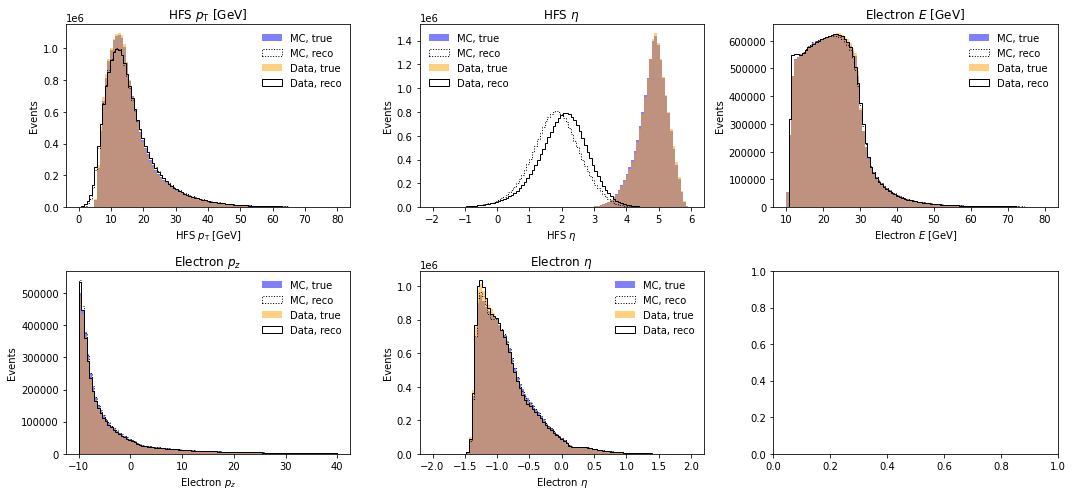

In [18]:
N = len(obs_features)

binning = [np.linspace(0,80,100),np.linspace(-2,6,100),
           np.linspace(10,80,100),np.linspace(-10,40,100),np.linspace(-2,2,100)]

fig, axes = plt.subplots(2, 3, figsize=(15,7))

for i,ax in enumerate(axes.ravel()):
    if (i >= N): break
    _,_,_=ax.hist(theta0_G[:,i],binning[i],color='blue',alpha=0.5,label="MC, true")
    _,_,_=ax.hist(theta0_S[:,i],binning[i],histtype="step",color='black',ls=':',label="MC, reco")
    _,_,_=ax.hist(theta_unknown_G[:,i],binning[i],color='orange',alpha=0.5,label="Data, true")
    _,_,_=ax.hist(theta_unknown_S[:,i],binning[i],histtype="step",color='black',label="Data, reco")

    ax.set_title(labels[i])
    ax.set_xlabel(labels[i])
    ax.set_ylabel("Events")
    ax.legend(frameon=False)
    
fig.tight_layout()

In [19]:
inputs = Input((len(obs_features), ))
hidden_layer_1 = Dense(50, activation='relu')(inputs)
hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
outputs = Dense(1, activation='sigmoid')(hidden_layer_3)
model_dis = Model(inputs=inputs, outputs=outputs)

In [20]:
N_Iterations = 2

myweights = of.omnifold(theta0_G,theta0_S,theta_unknown_S,N_Iterations,model_dis)

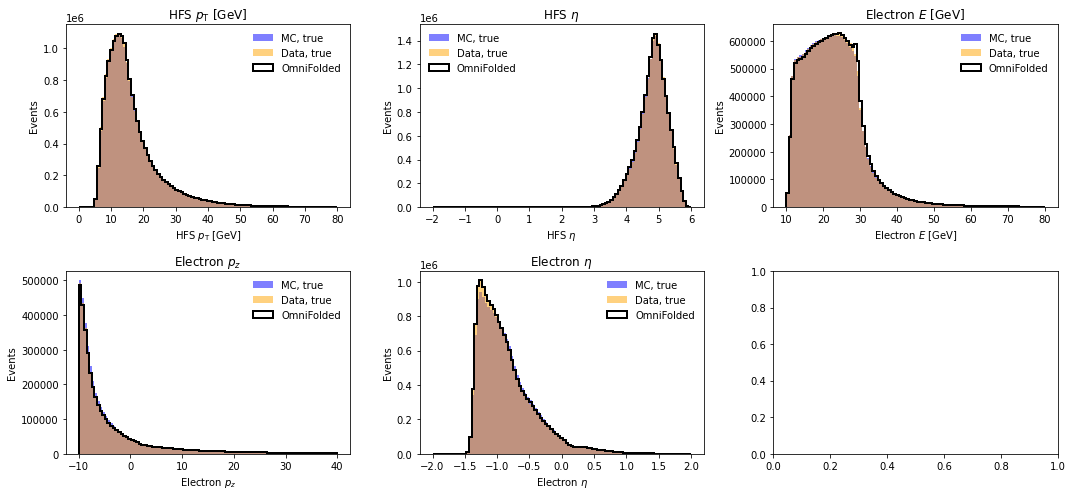

In [22]:
fig, axes = plt.subplots(2, 3, figsize=(15,7))

for i,ax in enumerate(axes.ravel()):
    if (i >= N): break
    _,_,_=ax.hist(theta0_G[:,i],binning[i],color='blue',alpha=0.5,label="MC, true")
    _,_,_=ax.hist(theta_unknown_G[:,i],binning[i],color='orange',alpha=0.5,label="Data, true")
    _,_,_=ax.hist(theta0_G[:,i],weights=myweights[-1, 0, :],bins=binning[i],color='black',histtype="step",label="OmniFolded",lw="2")

    ax.set_title(labels[i])
    ax.set_xlabel(labels[i])
    ax.set_ylabel("Events")
    ax.legend(frameon=False)
    
fig.tight_layout()

___
___

# OmniFold: DIY

### 1. Add Features, or create your own. Add iterations to the unfolding
careful adding both: might take a while!

### 2. Plot _unfolded_ electron observables: $\Sigma_e = E_e - p_{z,e}, \ \ \theta = 2\arctan(e^{-\eta})$

hint: unfolded distributions are just weighted histograms

### 3. Plot at _unfolded_ x,y, and $Q^2$ distribution

Hint: $y = 1-\frac{\Sigma_e}{2E_0}, \ \ Q^2 = \frac{E^2sin^2\theta}{1-y}, \ \ x\cdot E_p = \frac{E(1+\cos\theta)}{2y}$